# `Baseline` - Multispecies Leaf Disease Classification 🍃 

## Objective 🎯
Train a machine learning model to identify diseased from healthy tree leaves. Initial model will perform a binary healthy / diseased classifier. Follow-on models will add categorical information to identify the species as well as health of the leaves.

## Introduction 📋
* The dataset from kaggle contains images of leaves from 11 species of trees such as `lemon`, `mango`, and `pomegranite`. 
* A total of `4503` jpeg image files at `6k X 4k RGB pixel resolution`
* `2278` healthy leaves and `2225` diseased leaves. 
* The dataset comes decomposed into training, testing, validation, and prediction images, therefore our EDA and model building will not further segregate data into training and other sets. 

The test and training labels are determined by the placement folder for each image file. For example, an image file stored in the folder "Guava diseased" is considered to have binary label = 1 to indicate a diseased leaf image. Based on this file folder location structure, our model will generate a binary label array.

## Preprocessing & EDA 🔭

In [1]:
import pathlib
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import pandas as pd
import numpy as np

# ignore tensorflow & opencv debug & warning information by setting log level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from PIL import Image
import cv2

# import models created for baseline experiment
from baseline_models import train_and_evaluate, build_model

Set configs

In [2]:
IMG_DIR: str = "Plants_2_compressed"

# store the filepath address of the current file
__file__: str = os.path.abspath('')

ROOT_DIR_PATH: str = os.path.join(pathlib.Path(__file__).parent.parent)
IMG_DIR_PATH: str = os.path.join(ROOT_DIR_PATH, "data", IMG_DIR)

Initial baseline model will train and test on the lemon species and before the final project is completed all 11 specifies will be modeled.

In [3]:
healthy_cand_spec: str = "Lemon healthy (P10a)"
diseased_cand_spec: str = "Lemon diseased (P10b)"

Find image file names from local store directory

In [4]:
imgfiles_healthy_train: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "train", healthy_cand_spec))
imgfiles_diseased_train: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "train", diseased_cand_spec))
imgfiles_healthy_test: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "test", healthy_cand_spec))
imgfiles_diseased_test: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "test", diseased_cand_spec))

Generate binary image labels: `0` = `healthy`, `1` = `diseased`

In [5]:
image_label_train: np.ndarray = np.zeros(len(imgfiles_healthy_train) + len(imgfiles_diseased_train))
image_label_train[len(imgfiles_healthy_train) :] = 1

image_label_test: np.ndarray = np.zeros(len(imgfiles_healthy_test) + len(imgfiles_diseased_test))
image_label_test[len(imgfiles_healthy_test) :] = 1

Load images to memory, healthy images first then diseased images. Convert to grayscale to minimize processing time

In [6]:
images_training: list[np.ndarray | None] = []
images_test: list[np.ndarray | None] = []

imgfiles_map: dict[str, list[str]] = dict(
    imgfiles_healthy_train=imgfiles_healthy_train, 
    imgfiles_diseased_train=imgfiles_diseased_train, 
    imgfiles_healthy_test=imgfiles_healthy_test, 
    imgfiles_diseased_test=imgfiles_diseased_test
)

In [7]:
for imgfile_collection_name, imgfile_collection in imgfiles_map.items():
    batch_val: str = imgfile_collection_name.split("_")[-1]
    spec_feat: str = imgfile_collection_name.split("_")[-2]
    spec_feat_path: str = healthy_cand_spec if spec_feat == "healthy" else diseased_cand_spec
    
    for imgf in imgfile_collection:
        f_path: str = os.path.join(IMG_DIR_PATH, batch_val, spec_feat_path, imgf)
        im: np.ndarray = cv2.imread(f_path)
        images_training.append(im) if batch_val == "train" else images_test.append(im)

print(len(images_training), len(images_test))

217 10


#### For exploratory analysis, display 25 random images from the training set
The images are well centered with the leaf showing prominently at the center against a differentiable background.

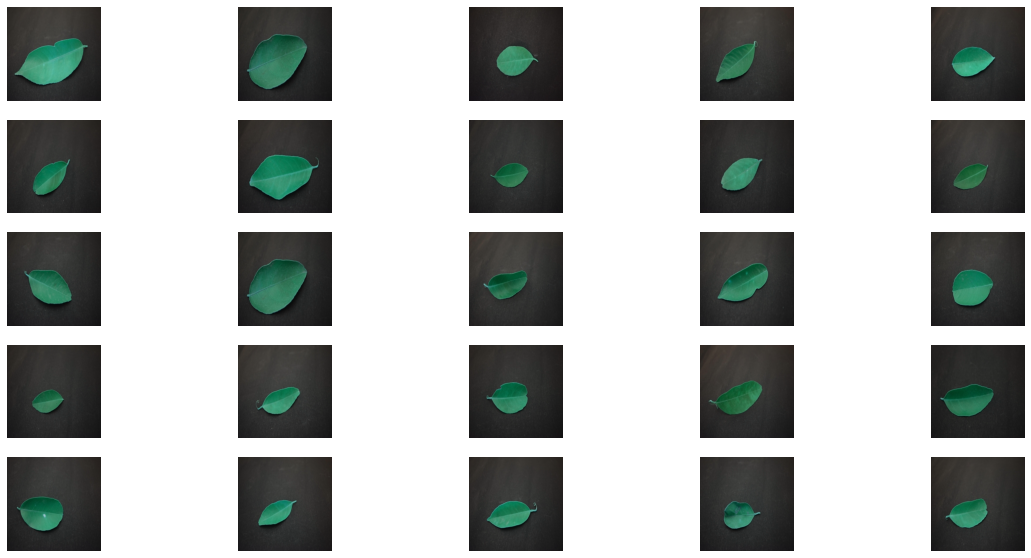

In [8]:
# Display some images
count = len(images_training) - 1

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,10))
for i in range(5):
    for j in range(5):
        indx = random.randint(0,count)
        axs[i][j].imshow(images_training[indx])
        axs[i][j].axis('off')
plt.show()

In [ ]:
%%time
result = train_and_evaluate(
    images_training=images_training,
    images_test=images_test,
    image_label_train=image_label_train,
    image_label_test=image_label_test
)

### Baseline Results
For a simple NN binary classifier, we look at accuracy, recall and precision metrics across epochs. This seemed reasonable for a simple model to assess performance across epochs. We achieve an accuracy of 0.6. This could be a consequence of information loss from resizing images to 256x256 although also ran the model at 512x512 resolution without improvement in the performance therefore will proceed with 256x, lower resolution but faster performance. The accuracy varies from 0.5 to 0.8 across multiple runs and would have expected more consistency. This may indicate a problem with the baseline model. Runninc more epochs ( > 15) gives a more consistent 0.6 accuracy.